In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
import time

import models
import flows

In [2]:
data = sio.loadmat("data.mat")

t = data["t"]
x = data["x"]
xi = data["xi"]
sols = data["sols"]

xx, tt = np.meshgrid(x[:, ::5], t[:, ::5])
xx = xx.reshape([-1, 1])
tt = tt.reshape([-1, 1])

# N tasks are used to train
N = 2000
u_test = sols[:, :, :N]
x_test = x
t_test = t

inputs_f = np.concatenate([xx, tt], axis=-1)


xx0, tt0 = np.meshgrid(x[:, ::5], 0)
xx0 = xx0.reshape([-1, 1])
tt0 = tt0.reshape([-1, 1])
inputs_0 = np.concatenate([xx0, tt0], axis=-1)
targets_0 = sols[0, ::5, :]
targets_0 = targets_0[:, :N]

In [3]:
x[:, ::5].shape

(1, 41)

In [4]:
targets_0.shape

(41, 2000)

In [5]:
t[:, ::5].shape

(1, 21)

In [3]:
inputs_f.shape

(861, 2)

In [4]:
inputs_0.shape, targets_0.shape

((41, 2), (41, 2000))

In [5]:
meta_model = models.MHPINN(num_tasks=N, dim=50, ws=[1, 1], name="mhpinn")

In [6]:
loss = meta_model.train(
    inputs_f, inputs_0, targets_0, niter=50000, ftol=1e-10,
)

0 0.033487067 , time:  1.5815887451171875
1000 0.0021120026 , time:  35.61618089675903
2000 0.0002990101 , time:  36.31517696380615
3000 0.00036662086 , time:  36.97458267211914
4000 0.00015332282 , time:  36.04767107963562
5000 0.00014794109 , time:  36.05396270751953
6000 0.00012465927 , time:  35.74951124191284
7000 0.00010796316 , time:  35.87303566932678
8000 8.474948e-05 , time:  35.505943775177
9000 6.033261e-05 , time:  35.84354853630066
10000 4.7848655e-05 , time:  35.8837890625
11000 2.6072015e-05 , time:  35.598554611206055
12000 1.7650636e-05 , time:  35.81135416030884
13000 1.4481793e-05 , time:  35.514541149139404
14000 1.1340426e-05 , time:  35.80167078971863
15000 8.640032e-06 , time:  35.7630090713501
16000 7.650078e-06 , time:  35.614147663116455
17000 6.3851758e-06 , time:  35.72514867782593
18000 5.674066e-06 , time:  35.59046697616577
19000 5.2460646e-06 , time:  35.75129795074463
20000 4.695774e-06 , time:  35.709388971328735
21000 4.4405324e-06 , time:  35.460181

In [7]:
meta_model.restore()
xx_test, tt_test = np.meshgrid(x_test, t_test)
inputs_test = tf.constant(
    np.concatenate([xx_test.reshape([-1, 1]), tt_test.reshape([-1, 1])], axis=-1), tf.float32,
)
u_pred = meta_model.call(
    tf.constant(inputs_test, tf.float32), meta_model.heads
).numpy()
u_pred = u_pred.reshape([101, 201, N])

In [8]:
x_test.shape

(1, 201)

In [9]:
u_pred.shape

(101, 201, 2000)

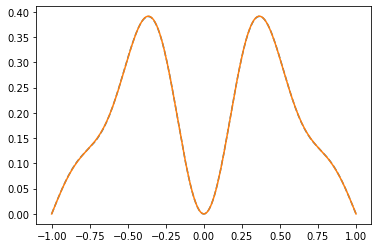

In [10]:
i, j = 0, 999
plt.plot(x_test.flatten(), u_pred[i, :, j], '--')
plt.plot(x_test.flatten(), sols[i, :, j])
# plt.plot(inputs_0[:, 0:1], targets_0[:, j], 'o')

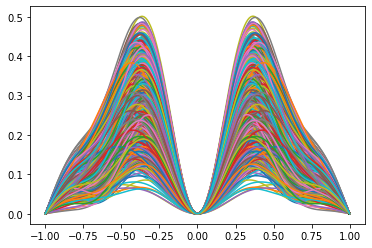

In [11]:
for i in range(1000):
    plt.plot(x_test.flatten(), u_pred[0, :, i])

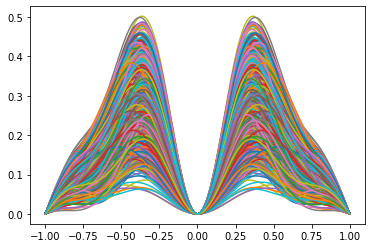

In [12]:
for i in range(1000):
    plt.plot(x_test.flatten(), sols[0, :, i])

In [13]:
L2 = np.sqrt(np.sum(np.sum((u_pred - sols[:, :, :N]) **2, axis=0), axis=0) / np.sum(np.sum(sols[:, :, :N]**2, axis=0), axis=0))

In [14]:
np.mean(L2)

0.000906144990520689

#### Distribution learning

In [16]:
permutation = list(np.arange(26, 51, 1)) + list(np.arange(0, 26, 1))

nf = flows.MAF(
    dim=51,
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
    name="maf_mhpinn",
)
heads = meta_model.heads.numpy().T

In [17]:
t2 = time.time()
loss = nf.train_batch(tf.constant(heads, tf.float32), nepoch=500)
t3 = time.time()

0 5.476769
Elapsed:  3.9434988498687744
1 -74.68956
Elapsed:  0.17531394958496094
2 -108.57847
Elapsed:  0.16245102882385254
3 -125.63932
Elapsed:  0.1740427017211914
4 -140.60913
Elapsed:  0.2821471691131592
5 -141.805
Elapsed:  0.16523408889770508
6 -138.7125
Elapsed:  0.114013671875
7 -130.26384
Elapsed:  0.11789989471435547
8 -151.05753
Elapsed:  0.1693406105041504
9 -95.02625
Elapsed:  0.10027432441711426
10 -105.450874
Elapsed:  0.12546753883361816
11 -149.5271
Elapsed:  0.10499405860900879
12 -161.25539
Elapsed:  0.1667170524597168
13 -163.61647
Elapsed:  0.17182374000549316
14 -161.11868
Elapsed:  0.10028529167175293
15 -168.57706
Elapsed:  0.1784071922302246
16 -166.54193
Elapsed:  0.10650134086608887
17 -135.53786
Elapsed:  0.10026788711547852
18 -171.43385
Elapsed:  0.1735668182373047
19 -177.0838
Elapsed:  0.17381620407104492
20 -182.70972
Elapsed:  0.1697688102722168
21 -179.63448
Elapsed:  0.1159060001373291
22 -167.57634
Elapsed:  0.10927915573120117
23 -189.69556
Elapse

188 -202.78229
Elapsed:  0.12057113647460938
189 -247.44405
Elapsed:  0.11126184463500977
190 -243.71402
Elapsed:  0.10856485366821289
191 -236.44016
Elapsed:  0.11337757110595703
192 -246.16843
Elapsed:  0.11899971961975098
193 -249.34035
Elapsed:  0.11900067329406738
194 -241.15297
Elapsed:  0.11999893188476562
195 -249.5625
Elapsed:  0.18200039863586426
196 -235.41785
Elapsed:  0.10716795921325684
197 -231.452
Elapsed:  0.10027074813842773
198 -245.03691
Elapsed:  0.11874675750732422
199 -250.769
Elapsed:  0.15964126586914062
200 -205.51819
Elapsed:  0.11190104484558105
201 -234.41956
Elapsed:  0.11078667640686035
202 -244.52371
Elapsed:  0.11055541038513184
203 -249.45488
Elapsed:  0.10518908500671387
204 -248.0344
Elapsed:  0.1144721508026123
205 -244.44156
Elapsed:  0.11701822280883789
206 -250.21121
Elapsed:  0.11035323143005371
207 -226.45552
Elapsed:  0.10577797889709473
208 -247.36053
Elapsed:  0.11281466484069824
209 -251.78766
Elapsed:  0.1556105613708496
210 -193.03535
Ela

372 -260.15268
Elapsed:  0.10839223861694336
373 -264.02264
Elapsed:  0.10657668113708496
374 -261.34427
Elapsed:  0.10731768608093262
375 -257.67847
Elapsed:  0.10280561447143555
376 -260.76575
Elapsed:  0.11294174194335938
377 -242.00081
Elapsed:  0.09863495826721191
378 -264.34296
Elapsed:  0.10027432441711426
379 -245.99457
Elapsed:  0.11583685874938965
380 -258.84692
Elapsed:  0.10027027130126953
381 -266.60095
Elapsed:  0.17274117469787598
382 -256.31345
Elapsed:  0.11228132247924805
383 -248.97635
Elapsed:  0.11249852180480957
384 -267.7714
Elapsed:  0.16619467735290527
385 -261.9192
Elapsed:  0.10901427268981934
386 -241.86583
Elapsed:  0.10677146911621094
387 -265.06793
Elapsed:  0.1083536148071289
388 -264.9013
Elapsed:  0.09867620468139648
389 -247.5851
Elapsed:  0.12286829948425293
390 -265.13266
Elapsed:  0.1088106632232666
391 -246.83803
Elapsed:  0.1309340000152588
392 -265.98837
Elapsed:  0.10084271430969238
393 -250.31262
Elapsed:  0.11557602882385254
394 -260.91006
El

In [18]:
nf.restore()
sample_fn = tf.function(nf.sample)
heads = sample_fn(1000)
# x_test = tf.constant(np.linspace(-1, 1, 128).reshape([-1, 1]), tf.float32)

# u_pred = meta.call(x_test, tf.transpose(heads))
# for i in range(1000):
#     plt.plot(x_test, u_pred[:, i])
# plt.ylim([-1.0, 0.5])
    
# plt.figure()
# for i in range(1000):
#     plt.plot(x_test, u_ref[:, i])
# plt.ylim([-1.0, 0.5])

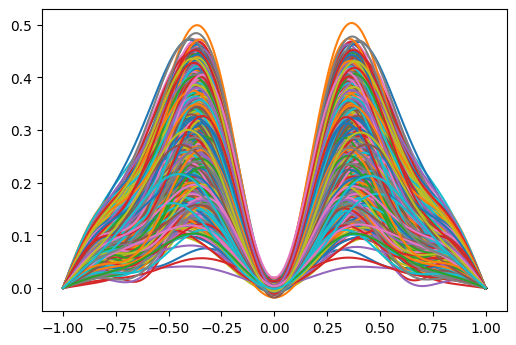

In [26]:
plt.figure(dpi=100)
xx_test, tt_test = np.meshgrid(x_test, t_test)
inputs_test = np.concatenate(
    [xx_test.reshape([-1, 1]), tt_test.reshape([-1, 1])], axis=-1
)
u_pred = meta_model.call(
    tf.constant(inputs_test, tf.float32), tf.transpose(heads),
).numpy()
u_pred = u_pred.reshape([101, 201, 1000])

for i in range(1000):
    plt.plot(x_test.flatten(), u_pred[0, :, i])
plt.savefig("learned.png")

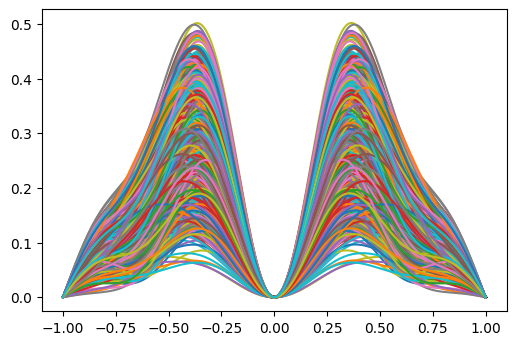

In [21]:
# plt.figure(dpi=100)
# u_pred = meta_model.call(
#     tf.constant(inputs_test, tf.float32), meta_model.heads,
# ).numpy()
# u_pred = u_pred.reshape([101, 201, 2000])

# for i in range(1000):
#     plt.plot(x_test.flatten(), u_pred[0, :, i])
# plt.savefig("training.png")

In [27]:
sio.savemat(
    "samples.mat",
    {
        "x": x_test,
        "trained": sols[0, :, :1000],
        "learned": u_pred[0, :, :1000],
    }
)

In [28]:
u_pred.shape

(101, 201, 1000)

#### Single PINN

In [156]:
np.random.seed(1234)
idx = np.random.choice(inputs_0.shape[0], inputs_0.shape[0], replace=False)[:10]
new_inputs_0 = inputs_0[idx, :]
new_targets_0 = targets_0[idx, 0:1]
idx = np.random.choice(inputs_f.shape[0], inputs_f.shape[0], replace=False)
new_inputs_f = inputs_f[idx, :]

In [157]:
model = models.PINN()

In [158]:
loss = model.train(new_inputs_f, new_inputs_0, new_targets_0, niter=20000)

0 0.041257344
1000 0.00069030275
2000 0.0002222062
3000 9.461059e-05
4000 0.000119929915
5000 3.5068115e-05
6000 3.329221e-05
7000 0.00015640783
8000 0.00012956464
9000 3.4525197e-05
10000 8.5990694e-05
11000 1.8458504e-05
12000 1.7655686e-05
13000 1.6059883e-05
14000 1.9618603e-05
15000 1.3894347e-05
16000 1.3000576e-05
17000 1.2501748e-05
18000 2.3689157e-05
19000 1.0531171e-05


In [159]:
model.restore()
xx_test, tt_test = np.meshgrid(x_test, t_test)
inputs_test = np.concatenate(
    [xx_test.reshape([-1, 1]), tt_test.reshape([-1, 1])], axis=-1
)
u_pred = model.call(
    tf.constant(inputs_test, tf.float32)
).numpy()
u_pred = u_pred.reshape([101, 201])

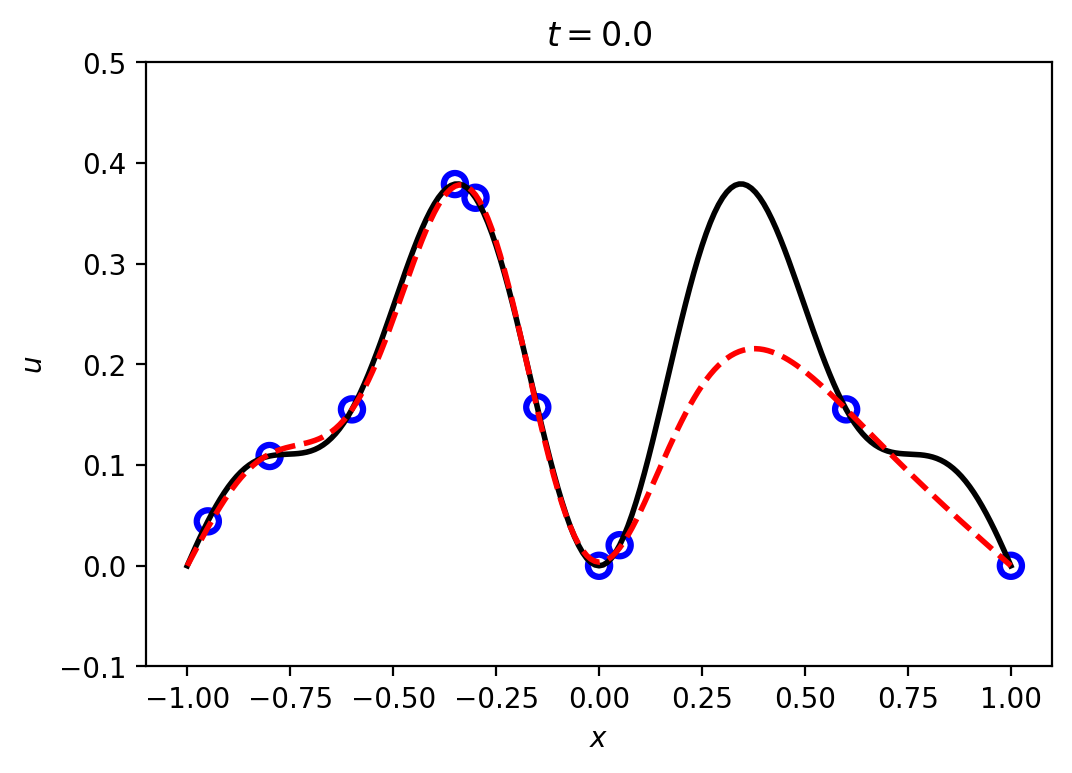

In [160]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
i = 0
ax.scatter(new_inputs_0[:, 0:1], new_targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), u_test[i, :, 0], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), u_pred[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("./figs/u_0_no.png")

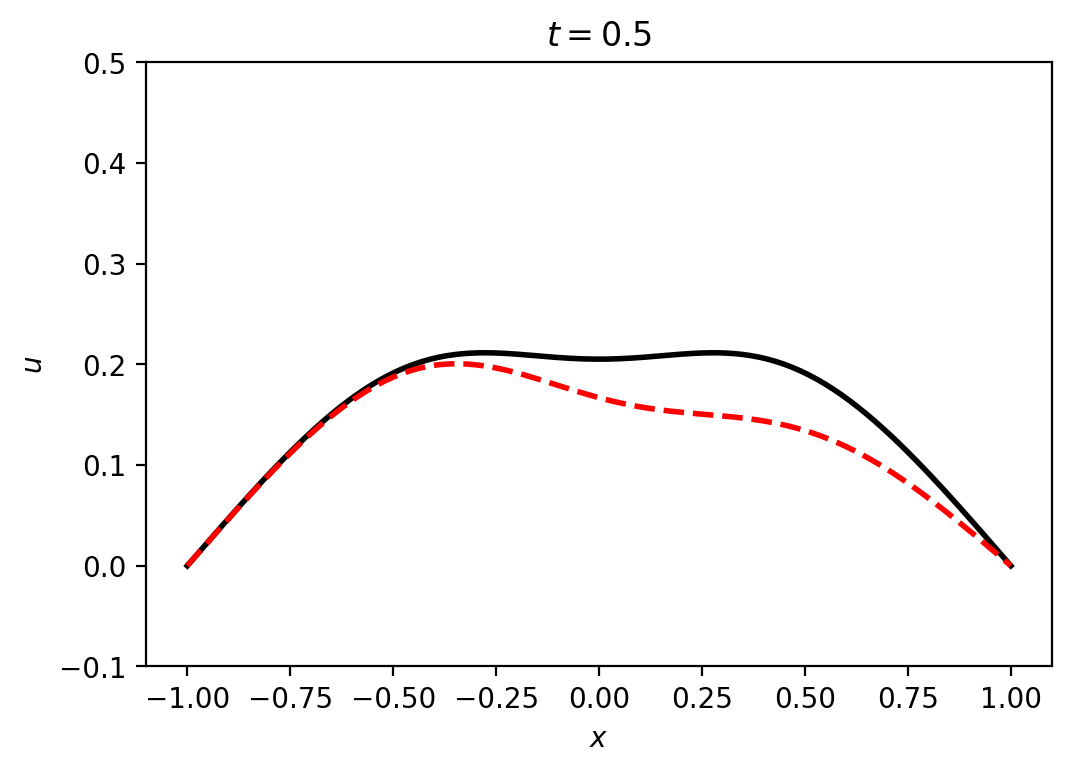

In [161]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
i = 50
# ax.scatter(new_inputs_0[:, 0:1], new_targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), u_test[i, :, 0], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), u_pred[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("./figs/u_1_no.png")

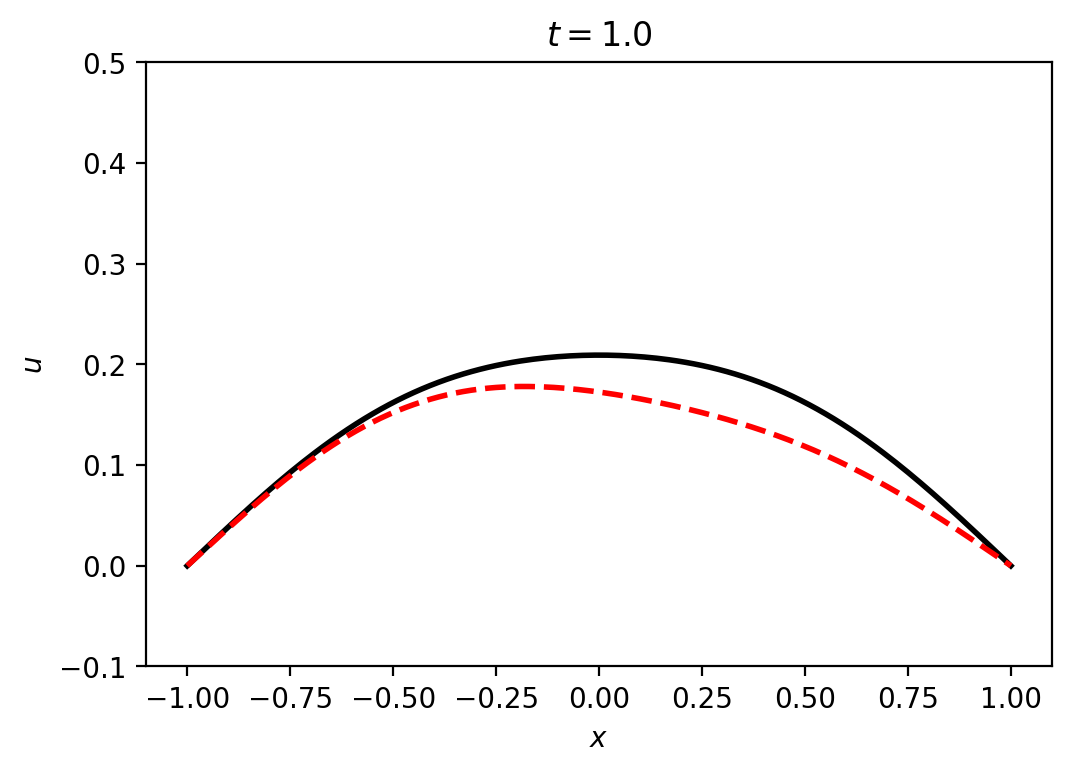

In [162]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
i = 100
# ax.scatter(new_inputs_0[:, 0:1], new_targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), u_test[i, :, 0], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), u_pred[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("./figs/u_2_no.png")

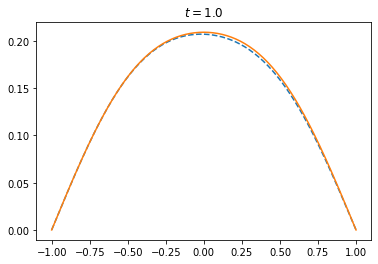

In [130]:
i = 100
plt.plot(x_test.flatten(), u_pred[i, :], '--')
plt.plot(x_test.flatten(), u_test[i, :, 0])
plt.title("$t=$"+str(t_test[:, i].reshape([])))
plt.show()

#### Meta-learning, without UQ

In [116]:
np.random.seed(1234)
idx = np.random.choice(inputs_0.shape[0], inputs_0.shape[0], replace=False)[:10]
new_inputs_0 = inputs_0[idx, :]
new_targets_0 = targets_0[idx, 0:1]
idx = np.random.choice(inputs_f.shape[0], inputs_f.shape[0], replace=False)
new_inputs_f = inputs_f[idx, :]

In [122]:
model = models.Model(body=meta_model, flow=nf, dim=50, eps=1e-10)
loss = model.train(new_inputs_f, new_inputs_0, new_targets_0, niter=20000)

0 0.49806443
1000 0.0020896965
2000 0.0012357025
3000 0.00075764605
4000 0.0005216674
5000 0.00038160395
6000 0.00028119134
7000 0.00019757258
8000 0.00013427861
9000 0.00010140022
10000 8.6601234e-05
11000 7.9431826e-05
12000 7.557834e-05
13000 7.331998e-05
14000 7.1883114e-05
15000 7.089921e-05
16000 7.017567e-05
17000 6.962336e-05
18000 7.733085e-05
19000 9.6796866e-05


In [134]:
model.restore()
xx_test, tt_test = np.meshgrid(x_test, t_test)
inputs_test = np.concatenate(
    [xx_test.reshape([-1, 1]), tt_test.reshape([-1, 1])], axis=-1
)
u_pred = model.call(
    tf.constant(inputs_test, tf.float32)
).numpy()
u_pred = u_pred.reshape([101, 201])

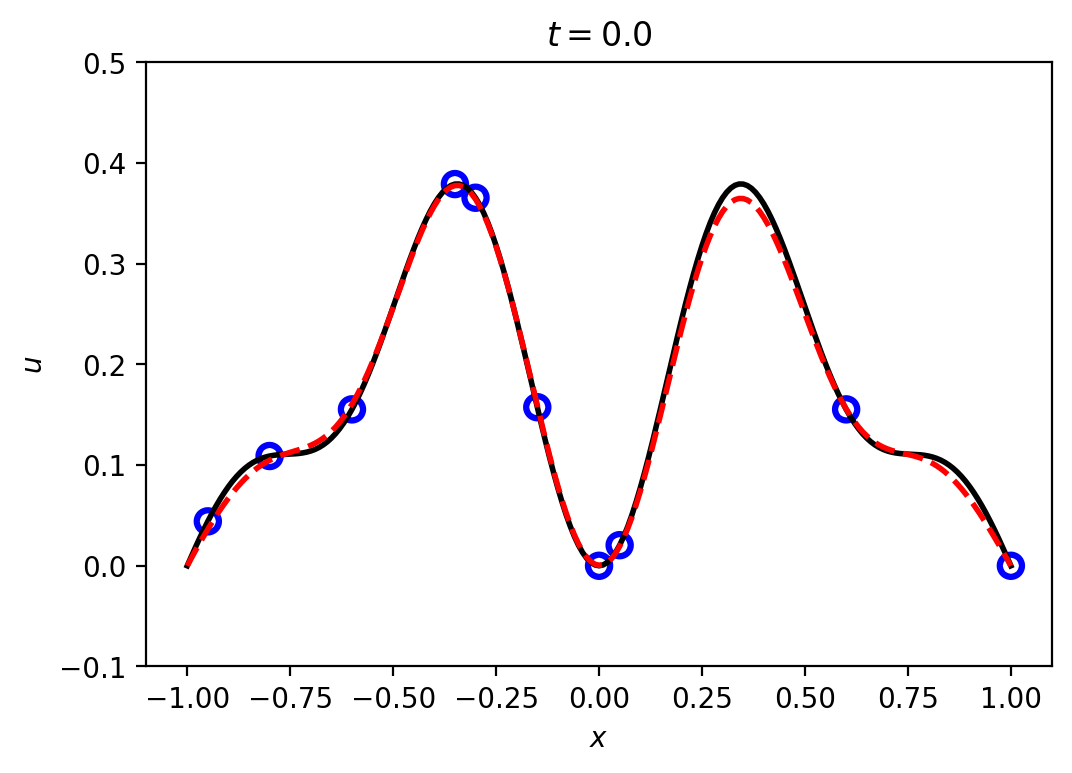

In [152]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
i = 0
ax.scatter(new_inputs_0[:, 0:1], new_targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), u_test[i, :, 0], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), u_pred[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("./figs/u_0.png")

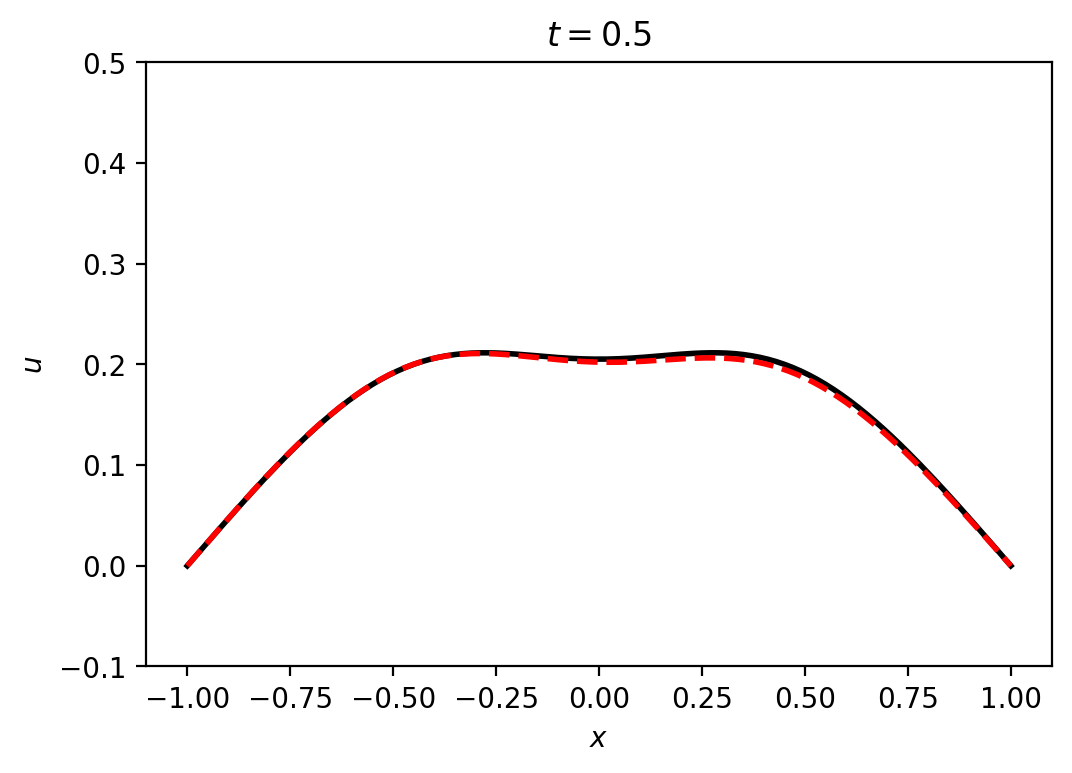

In [153]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
i = 50
# ax.scatter(new_inputs_0[:, 0:1], new_targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), u_test[i, :, 0], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), u_pred[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("./figs/u_1.png")

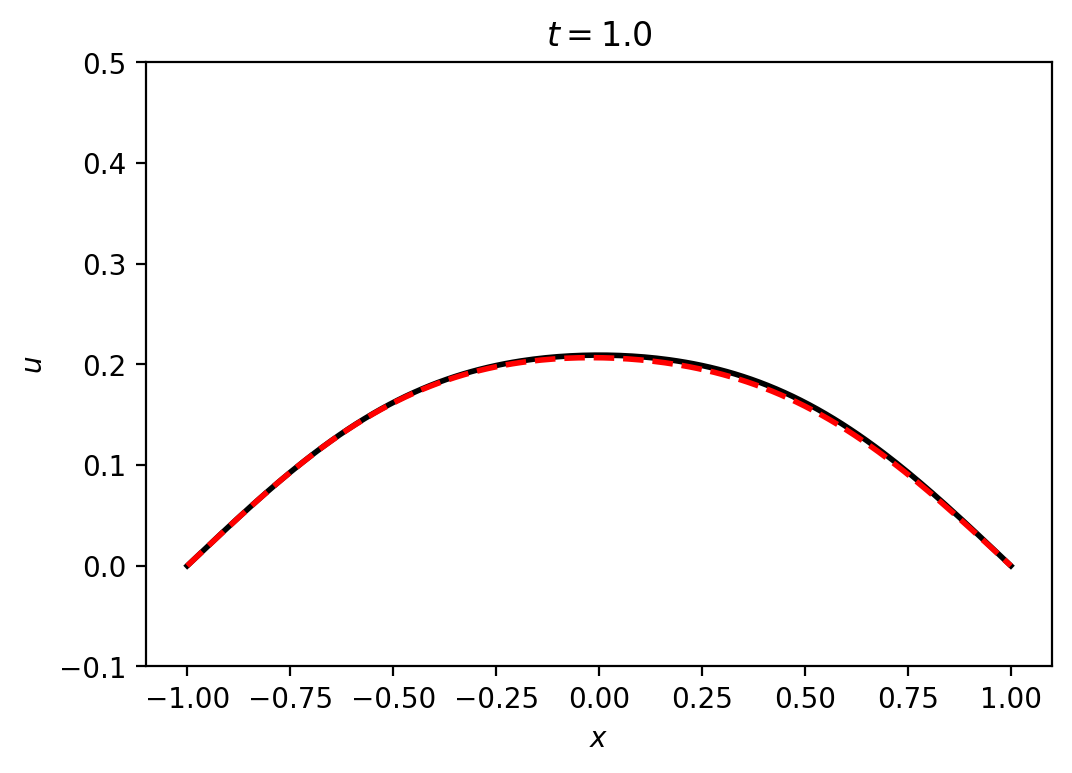

In [155]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
i = 100
# ax.scatter(new_inputs_0[:, 0:1], new_targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), u_test[i, :, 0], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), u_pred[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("./figs/u_2.png")

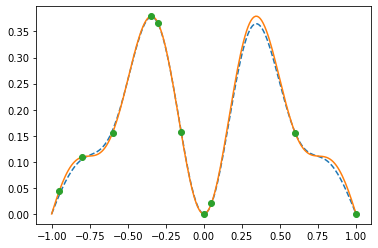

In [132]:
i = 0
plt.plot(x_test.flatten(), u_pred[i, :], '--')
plt.plot(x_test.flatten(), u_test[i, :, 0])
plt.plot(new_inputs_0[:, 0:1], new_targets_0, 'o')

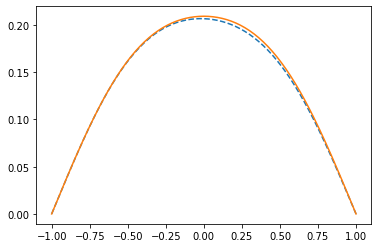

In [133]:
i = 100
plt.plot(x_test.flatten(), u_pred[i, :], '--')
plt.plot(x_test.flatten(), u_test[i, :, 0])

#### Meta-learning with UQ